In [2]:
#### 
import torch
import sys
sys.path.append("..")
import numpy as np
CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0"
REF_PATH = "/home/yifan/dataset/resnet18_init/pairflip/cifar10/0"


DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
ref_datainit = DataInit(REF_PATH,200)
tar_datainit = DataInit(CLEAN_PATH,200)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=200,TAR_EPOCH=200,model=ref_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18, 1)



NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 6646.86it/s]

NET resnet18_with_dropout


AttributeError: module 'Model.model' has no attribute 'resnet18_with_dropout'

In [35]:
tar_label =tar_provider.train_labels(200)
ref_label = ref_provider.train_labels(200)

In [36]:
k=0
for i in range(len(ref_prediction_res)):
    if ref_label[i] != tar_label[i]:
        k = k+1


In [42]:
ref_prediction_res

array([6, 9, 9, ..., 9, 1, 1])

In [41]:
tar_prediction_res

array([8, 0, 0, ..., 9, 0, 0])

In [25]:
k=0
for i in range(len(ref_prediction_res)):
    if ref_prediction_res[i] != tar_prediction_res[i]:
        k = k+1

In [26]:
k

49768

In [13]:
tar_provider.train_labels(200)

array([6, 9, 9, ..., 9, 1, 1])

In [7]:
ref_prediction_res

array([6, 9, 9, ..., 9, 1, 1])

In [29]:
tar_prediction_res

array([5, 5, 5, ..., 5, 5, 6])

In [28]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import rbf_kernel
from scipy.linalg import sqrtm

def transform_representation(X, Y, n_components):
    # Compute the kernel matrices for X and Y
    KX = rbf_kernel(X)
    KY = rbf_kernel(Y)

    # Center the kernel matrices
    n = KX.shape[0]
    KX_centered = KX - KX.mean(axis=0, keepdims=True) - KX.mean(axis=1, keepdims=True) + KX.mean()
    KY_centered = KY - KY.mean(axis=0, keepdims=True) - KY.mean(axis=1, keepdims=True) + KY.mean()

    # Compute the CKA between X and Y
    KX_sqrt = torch.DoubleTensor(sqrtm(KX_centered))
    KY_sqrt = torch.DoubleTensor(sqrtm(KY_centered))
    KX_inv_sqrt = torch.inverse(KX_sqrt)
    KY_inv_sqrt = torch.inverse(KY_sqrt)
    CKA_num = torch.trace(torch.mm(torch.mm(KX_inv_sqrt, torch.DoubleTensor(KY_centered)), KY_inv_sqrt))
    CKA_denom = torch.sqrt(torch.trace(torch.mm(torch.mm(KX_inv_sqrt, torch.DoubleTensor(KX_centered)), KX_inv_sqrt))) * torch.sqrt(torch.trace(torch.mm(torch.mm(KY_inv_sqrt, torch.DoubleTensor(KY_centered)), KY_inv_sqrt)))
    cka = CKA_num / CKA_denom

    # Apply PCA to X and Y
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    Y_pca = pca.fit_transform(Y)

    # Compute the kernel matrices for the transformed representations
    KX_transformed = rbf_kernel(X_pca)
    KY_transformed = rbf_kernel(Y_pca)

    # Center the kernel matrices for the transformed representations
    KX_transformed_centered = KX_transformed - KX_transformed.mean(axis=0, keepdims=True) - KX_transformed.mean(axis=1, keepdims=True) + KX_transformed.mean()
    KY_transformed_centered = KY_transformed - KY_transformed.mean(axis=0, keepdims=True) - KY_transformed.mean(axis=1, keepdims=True) + KY_transformed.mean()

    # Check the nearest neighbors
    dist_X = torch.cdist(torch.from_numpy(X_pca), torch.from_numpy(X_pca))
    dist_Y = torch.cdist(torch.from_numpy(Y_pca), torch.from_numpy(Y_pca))
    nn_X = torch.argsort(dist_X, axis=1)[:,1]
    nn_Y = torch.argsort(dist_Y, axis=1)[:,1]
    if torch.all(nn_X == nn_Y):
        print("Nearest neighbors are preserved.",nn_Y,nn_X)
    else:
        print("Nearest neighbors are not preserved.",nn_Y,nn_X)

    return X_pca, Y_pca, cka


In [37]:
X = torch.randn(20, 1000) # Original representation for X
Y = torch.randn(20, 1000) # Original representation for Y
n_components = 3
X_pca, Y_pca, cka = transform_representation(X, Y, n_components)
print(X_pca, Y_pca, cka)

Nearest neighbors are not preserved. tensor([14,  0,  9, 13, 19, 15, 10, 15, 12,  2, 13, 18,  7,  3,  0,  5, 18, 19,
        16, 17]) tensor([ 7, 13, 11, 17,  6, 14,  4,  8,  7, 13, 12,  2, 17,  1,  5, 18, 12,  3,
        15, 11])
[[-1.13931669e+01 -2.91822608e+00 -1.02429693e+01]
 [ 5.82244504e+00 -3.87378254e+00 -1.32675231e+01]
 [ 2.06781230e-01  1.32589897e+01  3.26845324e+00]
 [-9.39761955e+00 -9.41902794e-01  5.78291475e+00]
 [ 8.55829329e+00  1.17848736e+01 -8.25256362e+00]
 [ 5.66335230e+00 -5.65190252e-03  1.23743363e+01]
 [ 1.03974462e+00  9.77072207e+00 -1.05477856e+01]
 [-1.07934543e+01 -8.51517777e+00 -4.95010699e+00]
 [-8.41295669e+00 -1.09050821e+01 -4.45806290e+00]
 [ 1.89391698e+01 -9.61422610e+00  5.99671157e-01]
 [ 1.11403915e+00 -8.90315363e+00  6.99259418e+00]
 [ 7.48087990e-01  9.46233260e+00  6.28161298e+00]
 [-1.42988457e+00 -6.15513999e+00 -3.17772433e-01]
 [ 1.25068320e+01 -5.92105528e+00 -6.21668006e+00]
 [ 3.63605485e+00 -2.70103700e+00  1.64535973e+01]
 [-6

In [3]:
import numpy as np
import rtd

rtd 1.0102338939905167
H0: num barcodes 0
H1: num barcodes 12
max0,976Barcode 1 = 0.29796043038368225
maxBarcode 1 = 0.29796043038368225
middleBarcode 1 = 0.19289836287498474


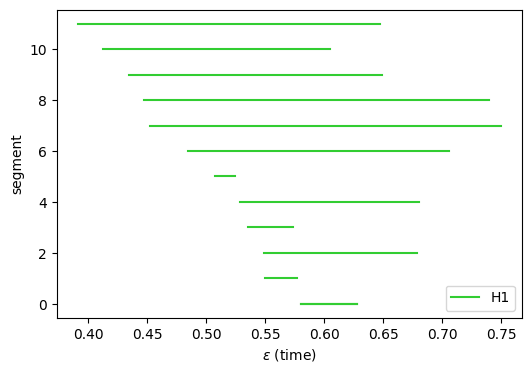

In [18]:
np.random.seed(7)

P = ref_train_data[pred_diff_class]
Q = tar_train_data[pred_diff_class]

barc = rtd.calc_embed_dist(P, Q)
print('rtd',rtd.rtd(P, Q))
rtd.plot_barcodes(rtd.barc2array(barc))


rtd 1.4505116790533066
H0: num barcodes 0
H1: num barcodes 20
max0,976Barcode 1 = 0.31474173069000244
maxBarcode 1 = 0.31474173069000244
middleBarcode 1 = 0.10952764749526978


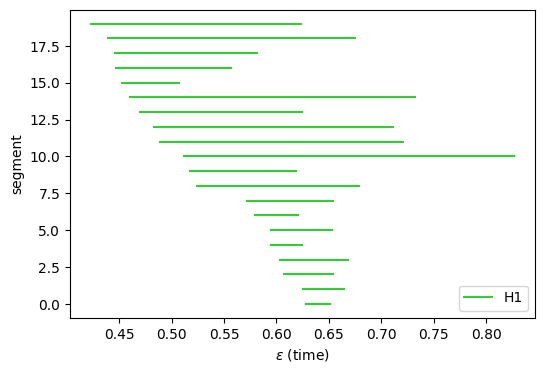

In [5]:
np.random.seed(7)

P = ref_train_data[pred_diff_list]
Q = tar_train_data[pred_diff_list]
print('rtd',rtd.rtd(P, Q))
barc = rtd.calc_embed_dist(P, Q)
rtd.plot_barcodes(rtd.barc2array(barc))

rtd 2.6610140949487686
H0: num barcodes 0
H1: num barcodes 13
max0,976Barcode 1 = 0.6039334237575531
maxBarcode 1 = 0.6039334237575531
middleBarcode 1 = 0.4114644527435303


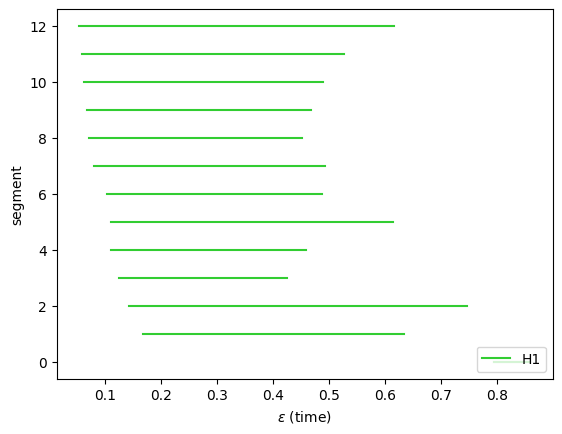

In [4]:
np.random.seed(7)

P = ref_train_data[same_indicates]
Q = tar_train_data[same_indicates]
print('rtd',rtd.rtd(P, Q))
barc = rtd.calc_embed_dist(P, Q)
rtd.plot_barcodes(rtd.barc2array(barc))

In [3]:
import torch
import numpy as np
from scipy.spatial.distance import pdist


def rbf(X, sigma=None):
    # X = torch.tensor(X)
    GX = torch.matmul(X, X.T)
    KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
    if sigma is None:
        mdist = torch.median(KX[KX != 0])
        sigma = torch.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = torch.exp(KX)
    return KX

def kernel_HSIC(X, Y, gamma):
    n1 = X.shape[0]
    n2 = Y.shape[0]
    H1 = torch.eye(n1) - torch.ones(n1, n1) / n1
    H2 = torch.eye(n2) - torch.ones(n2, n2) / n2
    K1 = torch.matmul(torch.matmul(H1, rbf(X, gamma)), H1)
    K2 = torch.matmul(torch.matmul(H2, rbf(Y, gamma)), H2)
    hsic = torch.trace(torch.matmul(K1, K2))
    return hsic

def cka(X, Y, sigma=None):
    hsic = kernel_HSIC(X, Y, sigma)
    var1 = torch.tensor(kernel_HSIC(X, X, sigma))
    var2 = torch.tensor(kernel_HSIC(Y, Y, sigma))
    cka = hsic / torch.sqrt(var1 * var2)
    return cka.item()


    
X = torch.randn(100, 10)
Y = torch.randn(100, 10)

cka_value = cka(X, Y)
print(cka_value)


from torch.optim import Adam


def objective_value(Y, X, gamma=None):
 
    K_xx = kernel_HSIC(X, X, gamma)
    K_yy = kernel_HSIC(Y, Y, gamma)
    # K_xy = rbf_kernel(X, Y, 1e-2) 
    K_xy = kernel_HSIC(X, Y, gamma)   
    cka = torch.mean(K_xy) / torch.sqrt(K_xx * K_yy)
    return cka

def objective(Y, X, gamma=None):
 
    K_xx = kernel_HSIC(X, X, gamma)
    K_yy = kernel_HSIC(Y, Y, gamma)
    # K_xy = rbf_kernel(X, Y, 1e-2) 
    K_xy = kernel_HSIC(X, Y, gamma)   
    cka_loss = 1 - torch.mean(K_xy) / torch.sqrt(K_xx * K_yy)
    return cka_loss

Y = torch.randn(100, 10, requires_grad=True)
optimizer = Adam([Y], lr=1e-2)



for i in range(10):
    loss = objective(X,Y)
    optimizer.zero_grad()
    loss.backward()
    print('loss',loss)
    optimizer.step()
    
print('RBF Kernel CKA, between same subset: {}'.format(objective_value(torch.Tensor(ref_train_data[same_indicates]), torch.Tensor(tar_train_data[same_indicates]))))
print('RBF Kernel CKA, between diff subset: {}'.format(objective_value(torch.Tensor(ref_train_data[pred_diff_list]), torch.Tensor(tar_train_data[pred_diff_list]))))
print('RBF Kernel CKA, between diff subset: {}'.format(objective_value(torch.Tensor(ref_train_data[pred_diff_class]), torch.Tensor(tar_train_data[pred_diff_class]))))
print('RBF Kernel CKA, between same+diff subset: {}'.format(objective_value(torch.Tensor(ref_train_data[diff_combine_same]), torch.Tensor(tar_train_data[diff_combine_same]))))

print('RBF Kernel CKA, between same subset: {}'.format(cka(torch.Tensor(ref_train_data[same_indicates]), torch.Tensor(tar_train_data[same_indicates]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_list]), torch.Tensor(tar_train_data[pred_diff_list]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_class]), torch.Tensor(tar_train_data[pred_diff_class]))))
print('RBF Kernel CKA, between same+diff subset: {}'.format(cka(torch.Tensor(ref_train_data[diff_combine_same]), torch.Tensor(tar_train_data[diff_combine_same]))))

0.15794813632965088
loss tensor(0.8178, grad_fn=<RsubBackward1>)
loss tensor(0.8129, grad_fn=<RsubBackward1>)
loss tensor(0.8079, grad_fn=<RsubBackward1>)
loss tensor(0.8029, grad_fn=<RsubBackward1>)
loss tensor(0.7978, grad_fn=<RsubBackward1>)
loss tensor(0.7927, grad_fn=<RsubBackward1>)
loss tensor(0.7876, grad_fn=<RsubBackward1>)
loss tensor(0.7824, grad_fn=<RsubBackward1>)
loss tensor(0.7771, grad_fn=<RsubBackward1>)
loss tensor(0.7718, grad_fn=<RsubBackward1>)
RBF Kernel CKA, between same subset: 0.9967558979988098
RBF Kernel CKA, between diff subset: 0.4922811985015869
RBF Kernel CKA, between diff subset: 0.6040273904800415
RBF Kernel CKA, between same+diff subset: 0.48917528986930847
RBF Kernel CKA, between same subset: 0.9967558979988098
RBF Kernel CKA, between diff subset: 0.4922811985015869
RBF Kernel CKA, between diff subset: 0.6040273904800415
RBF Kernel CKA, between same+diff subset: 0.48917528986930847


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [26]:
##### get R and S basdon on gamma
# Compute the Gram matrices for both tensors using the torch.matmul function:
A = torch.Tensor(ref_train_data[same_indicates])
B = torch.Tensor(tar_train_data[same_indicates])

G_A = torch.matmul(A, A.t())
G_B = torch.matmul(B, B.t())
# Compute the square roots of the diagonal matrices for both Gram matrices using the 
D_A = torch.sqrt(torch.diag(G_A))
D_B = torch.sqrt(torch.diag(G_B))
#Compute the inverse of the product of the diagonal matrices using the torch.inverse function:
D_A_inv = torch.inverse(torch.diag(D_A))
D_B_inv = torch.inverse(torch.diag(D_B))
#Compute the centered kernel matrices using the torch.mm function:
K_A = torch.mm(D_A_inv, torch.mm(G_A, D_A_inv))
K_B = torch.mm(D_B_inv, torch.mm(G_B, D_B_inv))
# Compute the SVD of the product of the centered kernel matrices using the torch.svd function:
U, _, V = torch.svd(torch.mm(K_A, K_B))
#Compute the rotation matrix as the product of the transposed matrices of U and V:
R = torch.mm(V.t(), U)
B_aligned = torch.mm(R, B)
S = torch.mm(U, V.t())
A_aligned = torch.mm(S, A)

In [4]:
from alignment.TrainingSnapshotAlignment import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,200,200 )

In [2]:
from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=200,TAR_EPOCH=200,model=net,DEVICE=DEVICE)

100%|██████████| 250/250 [00:00<00:00, 8631.04it/s]


In [4]:
a , b = gen.neibour_graph_build(ref_train_data, 20)

Tue Mar  7 12:14:14 2023 Building RP forest with 16 trees
Tue Mar  7 12:14:15 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	Stopping threshold met -- exiting after 4 iterations


In [ ]:
adjusted = gen.generate_representation_by_cka(18, 1,1000)

In [8]:
absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18, 1)

absolute alignment indicates number: 181 label diff indicates number: 39 confidence diff indicates number: 41 high distance number: 641


In [4]:
ress = tar_provider.get_pred(200, adjusted).argmax(axis=1)

100%|██████████| 1/1 [00:00<00:00, 3141.80it/s]


In [10]:
inidcates = high_distance_indicates
diff_combine_same = np.concatenate((absolute_alignment_indicates, inidcates), axis=0)

print('high distance sets CKA: {}'.format(np_cka.kernel_CKA(ref_train_data[inidcates], tar_train_data[inidcates])))
# print('init ref vs target diff CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[predict_label_diff_indicates], tar_train_data[predict_label_diff_indicates])))
print('adjusted vs target  CKA, between diff subset: {}'.format(np_cka.kernel_CKA(adjusted, tar_train_data[inidcates])))
print('adjusted vs reference  CKA, between diff subset: {}'.format(np_cka.kernel_CKA(adjusted, ref_train_data[inidcates])))
# print('adjusted vs reference diff CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, ref_train_data[predict_label_diff_indicates])))
print('target vs reference CKA, between diff+same subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])))
print('adjusted vs reference CKA, between diff+same subset: {}'.format(np_cka.kernel_CKA(np.concatenate((ref_train_data[absolute_alignment_indicates],adjusted), axis=0), tar_train_data[diff_combine_same])))

high distance sets CKA: 0.4862998352466789
adjusted vs target  CKA, between diff subset: 0.9664195678421265
adjusted vs reference  CKA, between diff subset: 0.5082681417063726
target vs reference CKA, between diff+same subset: 0.5416478268895032
adjusted vs reference CKA, between diff+same subset: 0.8920225570189145


In [11]:
representation = ref_provider.train_representation(200)
k = 0
for i in range(len(inidcates)):
    index = inidcates[i]
    representation[index] = adjusted[k]
    k = k + 1

In [12]:
ress = tar_provider.get_pred(200, adjusted).argmax(axis=1)
tar_prediction_res[predict_label_diff_indicates]
adjusted_Res = tar_provider.get_pred(200, adjusted).argmax(axis=1)
adjusted_Res_in_Ref = ref_provider.get_pred(200, adjusted).argmax(axis=1)
print('reference predict res',ref_prediction_res[predict_label_diff_indicates])

print('adjusted predict res ',adjusted_Res_in_Ref)
print('adjusted predict res ',adjusted_Res)
print(' target predict res  ',tar_prediction_res[predict_label_diff_indicates])

100%|██████████| 4/4 [00:00<00:00, 8093.21it/s]

reference predict res [7 4 5 7 6 9 2 2 4 4 8 8 3 4 3 7 0 9 0 5 5 7 9 3 5 1 3 5 9 8 3 8 3 0 1 7 6
 4 9]
adjusted predict res  [7 9 2 2 5 2 8 2 8 0 6 8 7 9 4 6 5 1 6 4 4 1 5 3 0 9 0 9 3 7 5 2 8 1 7 6 4
 4 2 0 3 0 3 1 5 9 9 1 1 8 5 2 8 7 9 0 9 7 2 0 2 4 0 8 4 0 3 2 4 9 3 8 1 2
 8 0 1 3 9 2 6 1 3 2 7 0 1 1 9 9 5 5 0 9 4 8 1 6 7 1 6 1 9 2 2 9 3 9 9 2 3
 3 3 1 9 9 1 1 5 1 7 6 7 6 5 4 3 2 0 3 9 1 8 2 1 3 2 3 1 5 5 9 8 0 3 5 9 3
 3 9 2 1 1 1 0 0 1 9 1 3 8 2 3 3 2 8 8 4 3 4 3 2 0 0 9 7 5 8 4 9 8 9 6 3 0
 1 5 7 2 5 2 2 1 6 8 9 5 9 1 2 9 1 5 9 0 5 1 1 2 7 2 5 5 1 3 5 7 5 9 8 6 8
 6 8 1 9 7 9 1 2 5 1 2 9 8 6 8 1 8 4 7 1 4 7 6 0 3 3 2 9 4 9 4 3 3 4 9 3 4
 9 1 1 9 1 1 2 9 9 6 1 1 1 1 1 2 1 2 9 3 3 2 1 4 6 8 0 7 1 2 4 8 3 0 9 0 0
 0 1 1 5 8 2 1 9 6 1 1 5 9 8 8 1 3 7 4 6 6 3 1 6 8 2 8 4 1 7 8 1 9 9 9 4 2
 1 5 1 1 8 9 6 0 4 5 2 1 2 4 5 6 1 1 2 7 9 1 9 7 1 4 6 5 5 8 9 8 9 4 2 5 9
 2 6 1 0 6 8 8 1 1 5 8 7 4 3 5 6 4 9 1 9 1 8 9 5 5 7 1 1 2 6 1 5 1 5 1 4 1
 2 9 6 9 7 9 2 6 2 8 8 8 7 1 4 9 2 2 3 3 1 2 3 6 3

In [13]:
from alignment.TrainingSnapshotAlignment import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,200,200 )

In [15]:
X = ref_train_data[absolute_alignment_indicates]
Y = tar_train_data[absolute_alignment_indicates]

R = alignment.align_embeddings(X,Y,25000)

iteration 0, loss 29572689.29619933
iteration 1000, loss 1445.7718757904581
iteration 2000, loss 820.3210049888838
iteration 3000, loss 544.2155774960733
iteration 4000, loss 390.21924935643926
iteration 5000, loss 293.7107175903671
iteration 6000, loss 228.66240866294171
iteration 7000, loss 182.53940669728442
iteration 8000, loss 148.57938266459323
iteration 9000, loss 122.83174267319147
iteration 10000, loss 102.84683245552257
iteration 11000, loss 87.03317914040218
iteration 12000, loss 74.31712512571269
iteration 13000, loss 63.9513837587367
iteration 14000, loss 55.40195670376396
iteration 15000, loss 48.27856231137473
iteration 16000, loss 42.29033115039748
iteration 17000, loss 37.21674374516587
iteration 18000, loss 32.88806955747419
iteration 19000, loss 29.17190008870193
iteration 20000, loss 25.963690023299492
iteration 21000, loss 23.17999362364768
iteration 22000, loss 20.75354986815833
iteration 23000, loss 18.62965850154399
iteration 24000, loss 16.76347215313186


In [22]:
X = ref_train_data[absolute_alignment_indicates]
Y = tar_train_data[absolute_alignment_indicates]

S = alignment.align_embeddings(Y,X,25000)

iteration 0, loss 26484562.452448882
iteration 1000, loss 1441.6453319041561
iteration 2000, loss 827.5571441853186
iteration 3000, loss 551.269315798626
iteration 4000, loss 396.3495285513873
iteration 5000, loss 298.93691455077385
iteration 6000, loss 233.11595294107732
iteration 7000, loss 186.3578220285199
iteration 8000, loss 151.88252726582107
iteration 9000, loss 125.71707994376581
iteration 10000, loss 105.39093267235735
iteration 11000, loss 89.29531913562826
iteration 12000, loss 76.34313466685619
iteration 13000, loss 65.77696686625573
iteration 14000, loss 57.05528784669303
iteration 15000, loss 49.78221380207374
iteration 16000, loss 43.66266936842954
iteration 17000, loss 38.47293336424879
iteration 18000, loss 34.040799031816604
iteration 19000, loss 30.231911986482196
iteration 20000, loss 26.940174875619373
iteration 21000, loss 24.08088746912272
iteration 22000, loss 21.585762797591265
iteration 23000, loss 19.39925283623259
iteration 24000, loss 17.47580313973849


In [36]:
predict_label_diff_indicates

[5645,
 9078,
 9132,
 12673,
 14647,
 18387,
 18957,
 22489,
 24758,
 28428,
 31156,
 36854,
 38741,
 39833,
 41478,
 46503,
 48685]

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9429.96it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

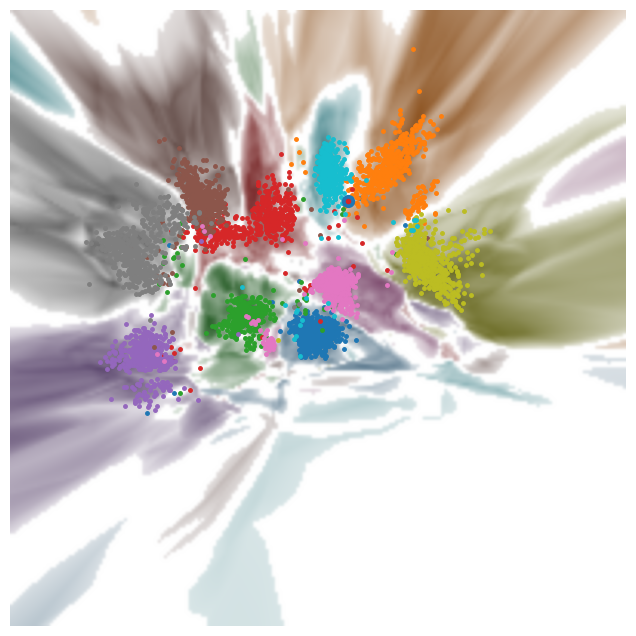

In [11]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
json_path ='/home/yifan/dataset/resnet18_with_adv_10%/cifar10/10/attack_indicates.json'
with open(json_path, 'r', encoding='utf-8') as file_obj:
    showList = json.load(file_obj)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [14]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
json_path ='/home/yifan/dataset/resnet18_with_adv_10%/cifar10/10/attack_indicates.json'
with open(json_path, 'r', encoding='utf-8') as file_obj:
    showList = json.load(file_obj)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R,I, np.dot(representation,I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

NameError: name 'R' is not defined

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9314.78it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

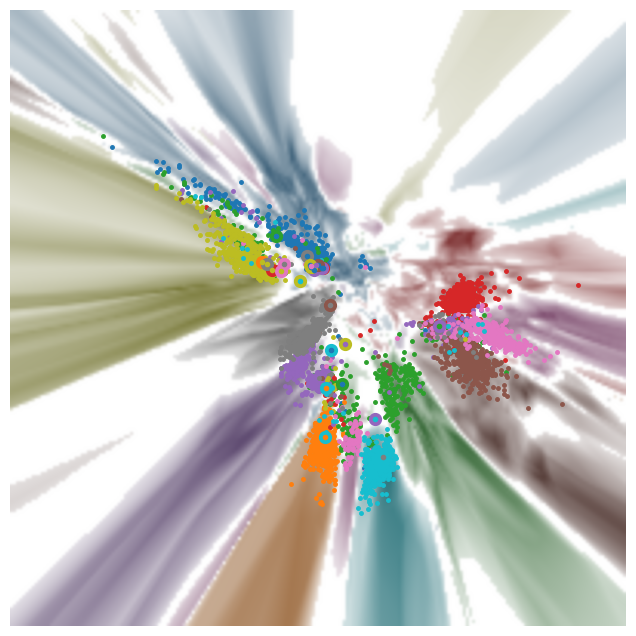

In [12]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
json_path ='/home/yifan/dataset/resnet18_with_adv_10%/cifar10/10/attack_indicates.json'
with open(json_path, 'r', encoding='utf-8') as file_obj:
    showList = json.load(file_obj)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_provider.train_representation(200),I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5419.00it/s]


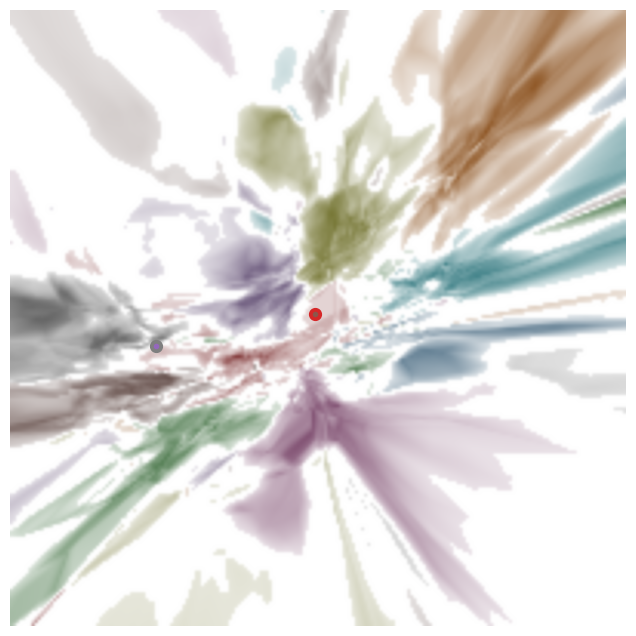

In [64]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
showList = [22489,24758,]


#  
#  
#  

#  
#  28428,
#  31156,
#  36854,
#  38741,
#  39833,
#  41478,
#  46503,
#  48685]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R,I, np.dot(representation,I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3880.02it/s]


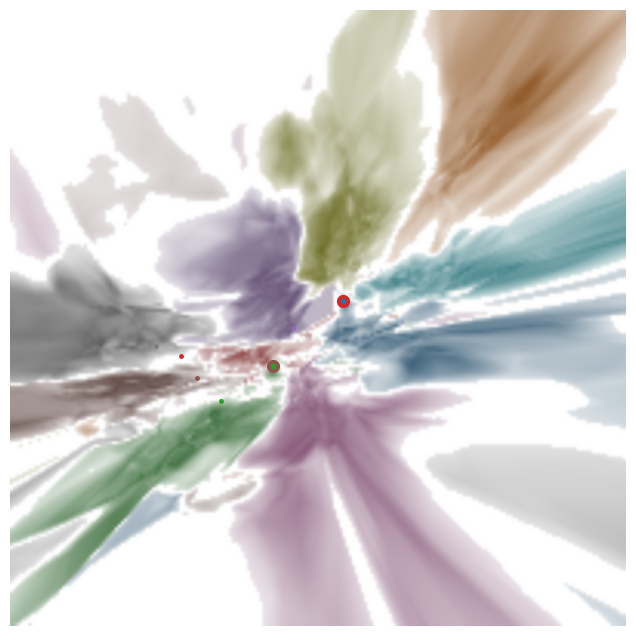

In [36]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
# showList = [5645,
#  9078,
#  9132,
#  12673,
#  14647,
#  18387,
#  18957,
#  22489,
#  24758,
#  28428,
#  31156,
#  36854,
#  38741,
#  39833,
#  41478,
#  46503,
#  48685]
showList = [5645,9078,12673,14647,24758,36854,39833]


#  
#  
#  
#  
#  
#  
#  
#  

#  
#  
#  
#  
#  48685]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(representation,I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9544.01it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

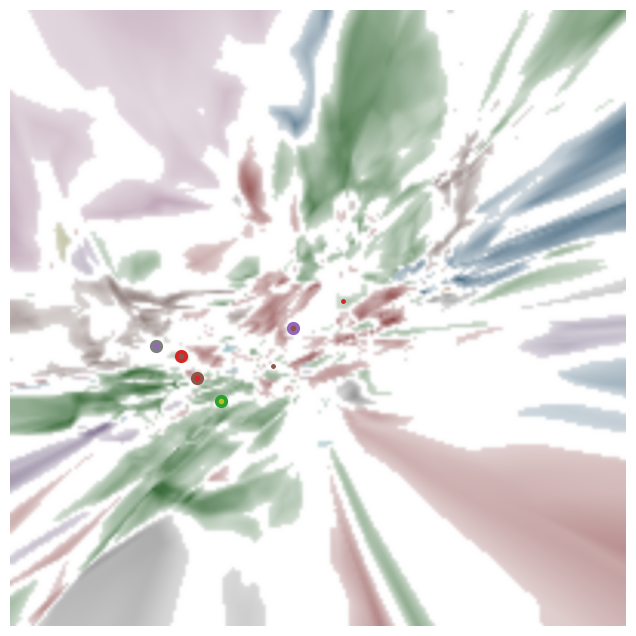

In [37]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
# showList = [5645,
#  9078,
#  9132,
#  12673,
#  14647,
#  18387,
#  18957,
#  22489,
#  24758,
#  28428,
#  31156,
#  36854,
#  38741,
#  39833,
#  41478,
#  46503,
#  48685]
showList = [5645,9078,12673,14647,24758,36854,39833]


#  
#  
#  
#  
#  
#  
#  
#  

#  
#  
#  
#  
#  48685]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(representation,I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3509.88it/s]


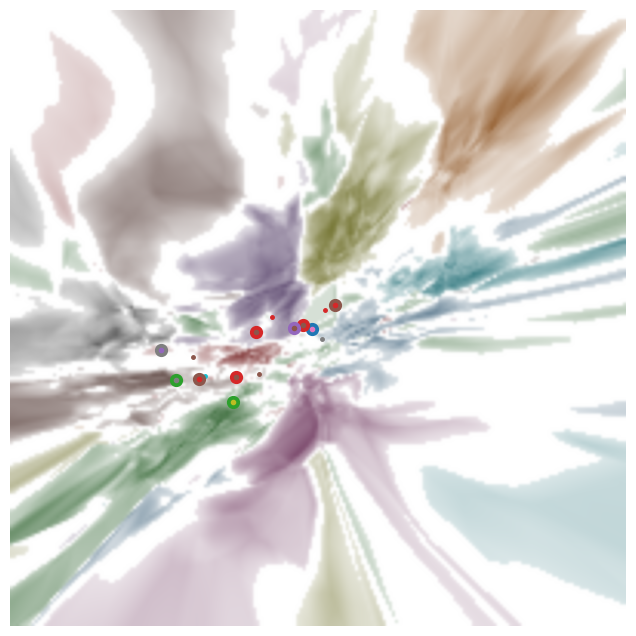

In [38]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R,I, np.dot(representation,I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [2]:
import json
import os
from singleVis.SingleVisualizationModel import SingleVisualizationModel
from singleVis.projector import TimeVisProjector
# model = VisModel(ENCODER_DIMS, DECODER_DIMS)
model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[showList],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

NameError: name 'predict_label_diff_indicates' is not defined

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9403.32it/s]
../representationTrans/trans_visualizer_border.py:186: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_data = self.data_provider.train_representation(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:187: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_labels = self.data_provider.train_labels(epoch)[self.indicates]
../representationTrans/trans_visualizer_border.py:188: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

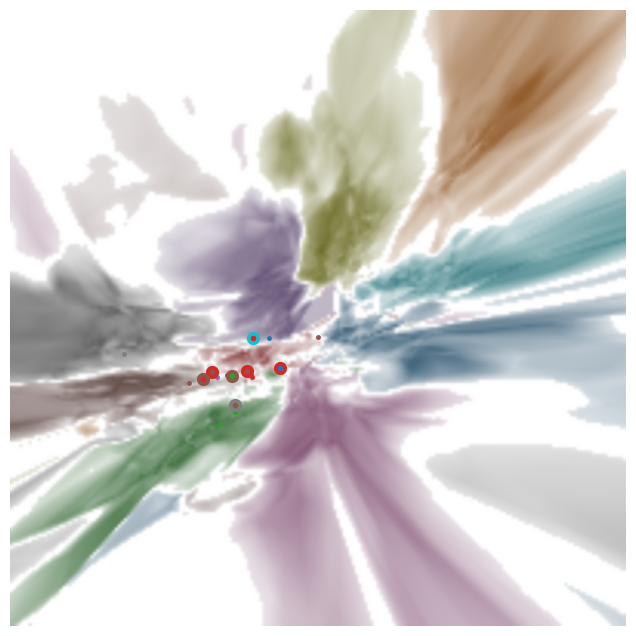

In [10]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_train_data,I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))



In [17]:
predict_label_diff_indicates

[5645,
 9078,
 9132,
 12673,
 14647,
 18387,
 18957,
 22489,
 24758,
 28428,
 31156,
 36854,
 38741,
 39833,
 41478,
 46503,
 48685]

In [23]:
need_drae = [14647,
 18387,
 18957,
 22489,
 24758,
 28428,
 31156,
 36854,
 38741,
 39833,
 41478,
 46503,
 48685]

Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9304.86it/s]


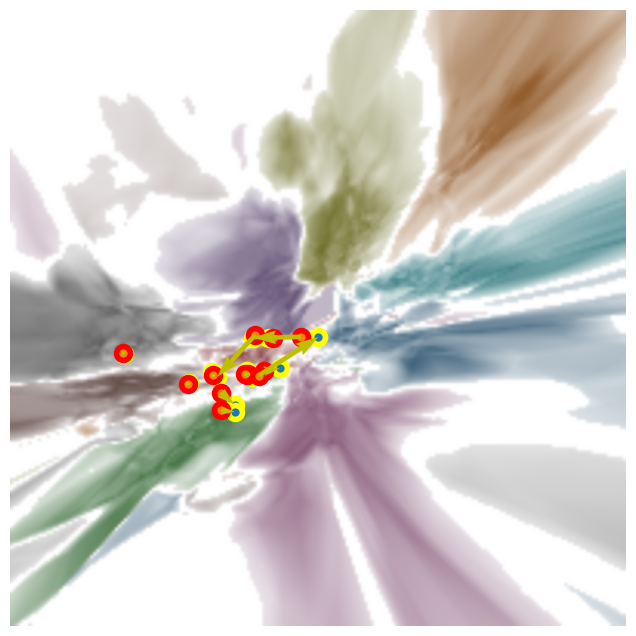

In [25]:
vis.savefig_trajectory(200, ref_provider.train_representation(150)[need_drae], '','',ref_provider.train_representation(200)[need_drae],'','',REF_PATH)

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 3218.96it/s]


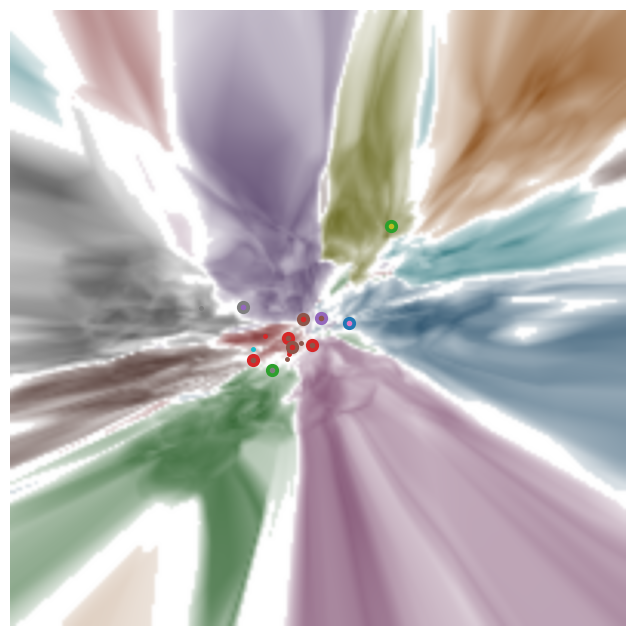

In [14]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
# model = SingleVisualizationModel(input_dims=512, output_dims=2, units=256, hidden_layer=4)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_provider.train_representation(200),I), projector, 200,[predict_label_diff_indicates],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [17]:
absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates = gen.subsetClassify(35, 1)
diff_combine_same = np.concatenate((absolute_alignment_indicates, predict_label_diff_indicates), axis=0)
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, tar_train_data[diff_combine_same])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, ref_train_data[diff_combine_same])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[predict_label_diff_indicates], tar_train_data[predict_label_diff_indicates])))
print('RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(aaa, tar_train_data[diff_combine_same])))


absolute alignment indicates number: 181 label diff indicates number: 39 confidence diff indicates number: 41 high distance number: 0


ValueError: too many values to unpack (expected 3)

In [23]:
len(diff_combine_same)

68

In [24]:
len(predict_label_diff_indicates)

17

In [20]:
need_update_arr = np.arange(51,len(diff_combine_same))

In [21]:
need_update_arr

array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

range(1, 101, 2)

In [12]:
# len(absolute_alignment_indicates)
aaa[:51]

array([[ 0.4438144 ,  0.25794092,  0.88561094, ..., -0.30997425,
         0.04925713,  0.7036765 ],
       [ 1.6506764 ,  0.62257606,  0.77443874, ...,  0.6457486 ,
         0.78697693,  1.9612937 ],
       [ 1.9230452 ,  1.8043541 ,  1.0690829 , ...,  1.2825058 ,
         2.058473  ,  2.411501  ],
       ...,
       [ 3.0967503 ,  0.83601546,  0.6276946 , ...,  0.3334073 ,
         0.04557479,  0.7800593 ],
       [ 0.29652357,  2.2157164 ,  1.0826873 , ...,  2.091645  ,
         1.8267734 ,  1.8171103 ],
       [ 2.123877  ,  1.9573641 ,  1.6897701 , ...,  1.3778095 ,
         2.8267016 ,  3.128074  ]], dtype=float32)

In [9]:
ref_train_data[absolute_alignment_indicates]

array([[0.35264334, 0.25828406, 0.83623934, ..., 0.        , 0.20785208,
        0.60769653],
       [1.7937965 , 0.5171929 , 0.2944022 , ..., 0.88652   , 1.0262028 ,
        1.7159932 ],
       [1.2522422 , 1.998488  , 1.3770924 , ..., 0.93216276, 1.8701797 ,
        2.7967405 ],
       ...,
       [2.7049246 , 0.6912097 , 0.3405223 , ..., 0.5076878 , 0.05851028,
        0.56205   ],
       [0.        , 1.9117651 , 1.4406421 , ..., 1.7921157 , 1.6261466 ,
        1.8802838 ],
       [1.8142302 , 1.6700609 , 1.9396539 , ..., 1.6751497 , 2.6756046 ,
        2.865216  ]], dtype=float32)

In [8]:
aaa

array([[ 0.4438144 ,  0.25794092,  0.88561094, ..., -0.30997425,
         0.04925713,  0.7036765 ],
       [ 1.6506764 ,  0.62257606,  0.77443874, ...,  0.6457486 ,
         0.78697693,  1.9612937 ],
       [ 1.9230452 ,  1.8043541 ,  1.0690829 , ...,  1.2825058 ,
         2.058473  ,  2.411501  ],
       ...,
       [ 1.2586628 , -0.02370401,  0.35129252, ...,  0.12940982,
         0.5937384 ,  0.4538625 ],
       [ 0.12163609,  1.2681662 ,  0.43215007, ...,  0.61959136,
        -0.26734826,  0.27205062],
       [-0.2988844 ,  1.0104567 ,  0.21589582, ...,  0.538526  ,
        -0.14185655, -0.20807993]], dtype=float32)

In [14]:
absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates = gen.subsetClassify(35, 1)

absolute alignment indicates number: 405 label diff indicates number: 17 confidence diff indicates number: 12


In [4]:
aaa

tensor([[ 3.0787e-01,  4.5586e-01,  1.2183e+00,  ...,  9.7048e-03,
          3.6762e-01,  9.9860e-02],
        [ 6.7021e-01,  2.3573e-02,  9.6027e-03,  ...,  9.2427e-05,
          8.9656e-01,  8.8440e-04],
        [ 0.0000e+00,  1.0089e-02,  1.1115e-02,  ...,  1.4065e+00,
          4.0381e-01,  0.0000e+00],
        ...,
        [-2.8396e-01,  2.0677e+00,  6.0495e-01,  ...,  4.7041e-01,
          1.5229e+00, -1.9884e-01],
        [ 1.5869e+00,  5.3166e-01,  1.1167e+00,  ...,  5.5588e-01,
          1.4619e+00, -1.5788e+00],
        [-3.7586e-01,  9.3878e-02, -2.0133e+00,  ...,  5.2337e-01,
          1.6253e+00,  1.2470e+00]], grad_fn=<CatBackward0>)

In [5]:
aaa

tensor([[ 3.0787e-01,  4.5586e-01,  1.2183e+00,  ...,  9.7048e-03,
          3.6762e-01,  9.9860e-02],
        [ 6.7021e-01,  2.3573e-02,  9.6027e-03,  ...,  9.2427e-05,
          8.9656e-01,  8.8440e-04],
        [ 0.0000e+00,  1.0089e-02,  1.1115e-02,  ...,  1.4065e+00,
          4.0381e-01,  0.0000e+00],
        ...,
        [-4.6379e-01, -3.9944e-01,  3.2981e-01,  ...,  4.5481e-01,
         -1.9631e+00,  1.5185e+00],
        [-1.1161e+00, -1.7232e+00, -9.9265e-01,  ..., -4.2883e-02,
         -1.0176e+00,  1.1383e+00],
        [-2.5949e-01, -8.4106e-02,  4.6334e-01,  ..., -4.1069e-01,
          2.6556e-01, -9.1836e-01]], grad_fn=<CatBackward0>)

In [60]:
import torch
import numpy as np
from scipy.spatial.distance import pdist

# def rbf_kernel(X, Y, gamma):
#     X_norms = (X ** 2).sum(dim=1, keepdim=True)
#     Y_norms = (Y ** 2).sum(dim=1, keepdim=True)
#     K = torch.exp(-gamma * (X_norms + Y_norms.T - 2 * torch.mm(X, Y.T)))
#     return K

def centering(K):
    n = K.shape[0]
    unit = torch.ones([n, n])
    I = torch.eye(n)
    H = I - unit / n
    K = torch.tensor(K)
    return torch.matmul(torch.matmul(H, K), H)

# def rbf(X, sigma=None):
#         GX = np.dot(X, X.T)
#         KX = np.diag(GX) - GX + (np.diag(GX) - GX).T
#         if sigma is None:
#             mdist = np.median(KX[KX != 0])
#             sigma = math.sqrt(mdist)
#         KX *= - 0.5 / (sigma * sigma)
#         KX = np.exp(KX)
#         return KX

def rbf(X, sigma=None):
    # X = torch.tensor(X)
    GX = torch.matmul(X, X.T)
    KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
    if sigma is None:
        mdist = torch.median(KX[KX != 0])
        sigma = torch.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = torch.exp(KX)
    return KX


def kernel_HSIC(X, Y, sigma):
    K_X = centering(rbf(X, sigma))
    K_Y = centering(rbf(Y, sigma))
    hsic = torch.sum(K_X * K_Y)
    return hsic.item()

def rbf_kernel(X, sigma=None):
    # X = torch.tensor(X)
    GX = torch.matmul(X, X.T)
    KX = torch.diag(GX) - GX + (torch.diag(GX) - GX).T
    if sigma is None:
        mdist = torch.median(KX[KX != 0])
        sigma = torch.sqrt(mdist)
    KX *= - 0.5 / (sigma * sigma)
    KX = torch.exp(KX)
    return KX


def cka(X, Y, sigma=None):
    K_X = centering(rbf(X, sigma))
    K_Y = centering(rbf(Y, sigma))
    hsic = torch.sum(K_X * K_Y)
    return hsic.item()
    
X = torch.randn(100, 10)
Y = torch.randn(100, 10)

cka_value = cka(X, Y)

def objective(Y, X=X, gamma=None):
    K_xx = rbf_kernel(X, gamma)
    K_yy = rbf_kernel(Y, gamma)
    K_xy = kernel_HSIC(X, Y, gamma)
    cka = torch.mean(K_xy) / torch.sqrt(torch.mean(K_xx) * torch.mean(K_yy))
    return -cka

from torch.optim import Adam

Y = torch.randn(100, 10, requires_grad=True)
optimizer = Adam([Y], lr=1e-2)

for i in range(10):
    loss = objective(Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)

Y = Y.detach().numpy()

print('RBF Kernel CKA, between same subset: {}'.format(cka(torch.Tensor(ref_train_data[same_indicates]), torch.Tensor(tar_train_data[same_indicates]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_list]), torch.Tensor(tar_train_data[pred_diff_list]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_class]), torch.Tensor(tar_train_data[pred_diff_class]))))
print('RBF Kernel CKA, between same+diff subset: {}'.format(cka(torch.Tensor(ref_train_data[diff_combine_same]), torch.Tensor(tar_train_data[diff_combine_same]))))


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


TypeError: new(): data must be a sequence (got float)

In [53]:
import torch
import numpy as np
from scipy.spatial.distance import pdist

def rbf_kernel(X, Y, gamma):
    X_norms = (X ** 2).sum(dim=1, keepdim=True)
    Y_norms = (Y ** 2).sum(dim=1, keepdim=True)
    K = torch.exp(-gamma * (X_norms + Y_norms.T - 2 * torch.mm(X, Y.T)))
    return K


def cka(X, Y, gamma=1e-2):
    K_xx = rbf_kernel(X, X, gamma)
    K_yy = rbf_kernel(Y, Y, gamma)
    K_xy = rbf_kernel(X, Y, gamma)
    cka = torch.mean(K_xy) / torch.sqrt(torch.mean(K_xx) * torch.mean(K_yy))
    return cka.item()
    
X = torch.randn(100, 10)
Y = torch.randn(100, 10)

cka_value = cka(X, Y)

def objective(Y, X=X, gamma=1e-2):
    K_xx = rbf_kernel(X, X, gamma)
    K_yy = rbf_kernel(Y, Y, gamma)
    K_xy = rbf_kernel(X, Y, gamma)
    cka = torch.mean(K_xy) / torch.sqrt(torch.mean(K_xx) * torch.mean(K_yy))
    return -cka

from torch.optim import Adam

Y = torch.randn(100, 10, requires_grad=True)
optimizer = Adam([Y], lr=1e-2)

for i in range(10):
    loss = objective(Y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(loss)

Y = Y.detach().numpy()

print('RBF Kernel CKA, between same subset: {}'.format(cka(torch.Tensor(ref_train_data[same_indicates]), torch.Tensor(tar_train_data[same_indicates]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_list]), torch.Tensor(tar_train_data[pred_diff_list]))))
print('RBF Kernel CKA, between diff subset: {}'.format(cka(torch.Tensor(ref_train_data[pred_diff_class]), torch.Tensor(tar_train_data[pred_diff_class]))))
print('RBF Kernel CKA, between same+diff subset: {}'.format(cka(torch.Tensor(ref_train_data[diff_combine_same]), torch.Tensor(tar_train_data[diff_combine_same]))))


tensor(-0.9984, grad_fn=<NegBackward0>)
tensor(-0.9985, grad_fn=<NegBackward0>)
tensor(-0.9987, grad_fn=<NegBackward0>)
tensor(-0.9988, grad_fn=<NegBackward0>)
tensor(-0.9989, grad_fn=<NegBackward0>)
tensor(-0.9990, grad_fn=<NegBackward0>)
tensor(-0.9991, grad_fn=<NegBackward0>)
tensor(-0.9992, grad_fn=<NegBackward0>)
tensor(-0.9993, grad_fn=<NegBackward0>)
tensor(-0.9994, grad_fn=<NegBackward0>)
RBF Kernel CKA, between same subset: 0.7649381160736084
RBF Kernel CKA, between diff subset: 0.882797122001648
RBF Kernel CKA, between diff subset: 0.8677344918251038
RBF Kernel CKA, between same+diff subset: 0.8875225782394409


In [ ]:
sss = cka(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same],)

In [ ]:

# Step2: Computing the loss 
def compute_loss(X, Y, R):
    '''
    Inputs: 
       X: a matrix of dimension (m,n) where the columns are the English embeddings.
       Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
       R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
       L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # m is the number of rows in X
    m = len(X)

    # diff is XR - Y
    diff = np.dot(X, R) - Y

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = diff_squared.sum()

    # loss is the sum_diff_squared divided by the number of examples (m)
    loss = sum_diff_squared/m
    ### END CODE HERE ###
    return loss
def compute_gradient(X, Y, R):
    '''
        the gradient of the loss with respect to the matrix encodes how much a tiny change 
    in some coordinate of that matrix affect the change of loss function.
        Gradient descent uses that information to iteratively change matrix R until we reach 
    a point where the loss is minimized.
    Inputs: 
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
       g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)

    rows, columns = X.shape

    gradient = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows
    assert gradient.shape == (columns, columns)
    ### END CODE HERE ###
    return gradient


# Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

# 1.Calculate gradient g of the loss with respect to the matrix R. 
# 2. Update R (Rnew = Rold - αg) . α is the learning rate which is a scalar.

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      train_steps:int,
                      learning_rate: float=0.0003,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])
    # R = Variable(torch.ones(X.shape[1],X.shape[1]),requires_grad=True)

   

        
    # train_steps = 100000
    for i in range(train_steps):
        if i%1000 == 0:
            loss = compute_loss(X,Y,R)
            print(f"iteration {i}, loss {loss}") 



        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X, Y, R)
       
        
         # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
        ### END CODE HERE ###
    
    return R


In [ ]:
len(pred_diff_class)
ref_train_data = ref_provider.train_representation(200).squeeze()
ref_res_idx = list(zip(range(len(ref_prediction_res)),ref_prediction_res))
ref_scores_idx = list(zip(range(len(ref_scores)),ref_scores))

for i in range(len(pred_diff_class)):
    index = pred_diff_class[i]
    ###### find same prediction result in reference
    pred_res_in_target = tar_prediction_res[index]
    score = tar_scores[index]
    res_idx = list(filter(lambda x:x[1]==pred_res_in_target,ref_res_idx))

    res_idx = list(zip(*res_idx))[0]
    if len(res_idx):
        score_idx = list(filter(lambda x:np.logical_and(x[0] in res_idx,math.fabs(x[1] - score) < 0.1),ref_scores_idx))
        
        if len(score_idx):
            score_idx = list(zip(*score_idx))[0]
            if i%10 == 0:
                print('111',index, score_idx[0])
            ref_train_data[index] = ref_train_data[score_idx[0]]


    # print('res',pred_res_in_target, 'res',len(score_idx))

In [ ]:
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]
S_for_same = align_embeddings(X, Y, 35000)

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

show_list = [pred_diff_class[0],pred_diff_class[1],pred_diff_class[7],pred_diff_class[8],pred_diff_class[14],pred_diff_class[16],
             pred_diff_class[18],
             pred_diff_class[20],pred_diff_class[25],pred_diff_class[29],pred_diff_class[30],pred_diff_class[32],pred_diff_class[33],
             pred_diff_class[42],pred_diff_class[43],pred_diff_class[44],pred_diff_class[45],
             ]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider , S_for_same,I, ref_train_data, projector, 200,[show_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
show_list = [pred_diff_class[0],pred_diff_class[1],pred_diff_class[7],pred_diff_class[8],pred_diff_class[14],pred_diff_class[16],
             pred_diff_class[18],
             pred_diff_class[20],pred_diff_class[25],pred_diff_class[29],pred_diff_class[30],pred_diff_class[32],pred_diff_class[33],
             pred_diff_class[42],pred_diff_class[43],pred_diff_class[44],pred_diff_class[45],
             ]
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[show_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
# use prediction differenct subset train S_for_diff, use S_for_diff generate diff predict samples
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]
R_for_same = align_embeddings(Y, X, 35000)

In [ ]:
# X = ref_train_data[diff_combine_same]
# Y = tar_train_data[diff_combine_same]
# S = align_embeddings(X, Y, 25000)
# X = ref_train_data[diff_combine_same]
# Y = tar_train_data[diff_combine_same]
# R = align_embeddings(Y, X, 25000)
# adjusted

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_same,I, np.dot(tar_provider.train_representation(200),R_for_same), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
diff_combine_same = np.concatenate((pred_diff_list, same_indicates), axis=0)

In [ ]:
# np.concatenate(ref_train_data[same_indicates], np.array([ref_train_data[index]])).shape


# samelist.append(ref_train_data[0])
# la = np.append(samelist, ref_train_data[0], axis=None) 
# la.shape   
# print(index,'RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same]))) 
stand = np_cka.kernel_CKA(ref_train_data[diff_combine_same], tar_train_data[diff_combine_same])                
for i in range(len(res_idx)):
    index = res_idx[i]
    samelist1 = ref_train_data[diff_combine_same]
    samelist1[0] = ref_train_data[index]

    if(stand - np_cka.kernel_CKA(samelist1, tar_train_data[diff_combine_same]) < 0.001):
        print(index,'RBF Kernel CKA, between diff subset: {}'.format(np_cka.kernel_CKA(samelist1, tar_train_data[diff_combine_same])))

    

    

In [ ]:
def find_sta_CKA(res_idx, need_adjust_index,ref_representations, tar_representations, threthold):
    """
        res_idx: search subset
        need_adjust_index: index of the need adjusted sample
        ref_representations: reference representation sub set
        tar_representations: target representation sub set
        threthold: current CKA
    """
    stand_val = np_cka.kernel_CKA(ref_representations, tar_representations)           
    idx = []
    for i in range(len(res_idx)):
        index = res_idx[i]
        ref_representations[need_adjust_index] = ref_train_data[index]

        if (stand_val - np_cka.kernel_CKA(ref_representations, tar_representations) < threthold):
            idx.append(index)
    return idx

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_same,I, np.dot(tar_provider.train_representation(200),R_for_same), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_for_same,I, np.dot(tar_provider.train_representation(200),R_for_same), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, I,I, np.dot(tar_provider.train_representation(200),I), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[pred_diff_list],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[pred_diff_class],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
X = np.dot(ref_train_data[pred_diff_list],S_for_diff)
Y = tar_train_data[pred_diff_list]
print('RBF Kernel CKA, between np.dot(ref_train_data[pred_diff_list],S_for_diff) and tar_train_data[pred_diff_list]: {}'.format(np_cka.kernel_CKA(X, Y)))